In [1]:
import pandas as pd

In [2]:
# pip install transformers

In [3]:
# pip install emoji

In [4]:
# pip install tqdm

In [5]:
df = pd.read_csv("../data/cleaned_data.csv")

In [6]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch
# import numpy as np
# import torch.nn.functional as F

# # Load tokenizer and model
# MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [7]:
# def get_roberta_sentiment_soft(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
#     with torch.no_grad():
#         logits = model(**inputs).logits
#     probs = F.softmax(logits, dim=1).numpy()[0]
#     labels = ['negative', 'neutral', 'positive']
#     return {
#         "label": labels[np.argmax(probs)],
#         "negative": float(probs[0]),
#         "neutral": float(probs[1]),
#         "positive": float(probs[2])
#     }

In [8]:
# df['sentiment_result'] = df['cleaned_text'].apply(get_roberta_sentiment_soft)

# # Split into separate columns
# df[['sentiment_label', 'neg_prob', 'neu_prob', 'pos_prob']] = df['sentiment_result'].apply(
#     lambda x: pd.Series([x['label'], x['negative'], x['neutral'], x['positive']])
# )

In [9]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch.nn.functional as F

# emotion_tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
# emotion_model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

# emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# def get_emotion(text):
#     inputs = emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
#     with torch.no_grad():
#         logits = emotion_model(**inputs).logits
#     probs = F.softmax(logits, dim=1).numpy()[0]
#     return {
#         "emotion": emotion_labels[np.argmax(probs)],
#         **{f"{label}_prob": float(prob) for label, prob in zip(emotion_labels, probs)}
#     }

# df['emotion_result'] = df['cleaned_text'].apply(get_emotion)

# # Expand columns
# df = pd.concat([df, df['emotion_result'].apply(pd.Series)], axis=1)

In [10]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from tqdm import tqdm

# OPTIONAL: if using HuggingFace API token for private models (not required here)
# import os
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'your_token_here'

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment classifier pipeline
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, return_all_scores=True)

# Sample: apply to your DataFrame
tqdm.pandas()

def get_sentiment_scores(text):
    try:
        result = classifier(text)[0]  # returns a list of dicts
        return {entry['label']: entry['score'] for entry in result}
    except:
        return {"LABEL_0": None, "LABEL_1": None, "LABEL_2": None}  # fallback

# Apply
df['sentiment_scores'] = df['cleaned_text'].progress_apply(get_sentiment_scores)

# Optional: Split scores into columns
df_sentiment = df['sentiment_scores'].apply(pd.Series)
df_sentiment.columns = ['Negative', 'Neutral', 'Positive']  # for this model's label order
df = pd.concat([df, df_sentiment], axis=1)

display(df[['cleaned_text', 'Negative', 'Neutral', 'Positive']].head(10))

/Users/rajanya/Documents/PCOD/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
/Users/rajanya/Documents/PCOD/venv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|███████████████████████████████████████████████████████████| 331/331 [00:09<00:00, 33.76it/s]


,cleaned_text,Negative,Neutral,Positive
0,help pcod routine please im f got diagnosed pc...,0.214990,0.689178,0.095832
1,pcod spotting jogging always wished body hiit ...,0.040413,0.513507,0.446080
2,building better tracking app focused right pro...,0.212760,0.443566,0.343674
3,client reversed year old pcod year tired tryin...,0.088365,0.717197,0.194438
4,possible get pregnant pcodpcos suffering pcod ...,0.306277,0.614954,0.078769
5,facial hair facing problem since last year ear...,0.823930,0.167068,0.009002
6,help pcod journey would want hey girlies someo...,0.104107,0.385542,0.510351
7,weight gain hairfall emotional breakdown im ye...,0.870763,0.118130,0.011106
8,nari saundarya malt help year old girl facing ...,0.268165,0.654631,0.077203
9,got diagnosed pcod recently got diagnosed pcod...,0.279792,0.681016,0.039192


In [11]:
df['sentiment_label'] = df[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)

/var/folders/p2/5zlctvqn3413625zm4c0bpfm0000gn/T/ipykernel_9104/40724881.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['sentiment_label'] = df[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)


In [12]:
df['sentiment_label'].value_counts()

sentiment_label
Neutral     170
Negative    107
Positive     52
Name: count, dtype: int64

In [13]:
## Emotions

In [14]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

# Enable tqdm in pandas
tqdm.pandas()

# Load the HuggingFace emotion model
emotion_classifier = pipeline(
    "text-classification", 
    model="j-hartmann/emotion-english-distilroberta-base", 
    return_all_scores=True
)

Device set to use mps:0
/Users/rajanya/Documents/PCOD/venv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [15]:
def get_emotion_scores(text):
    try:
        result = emotion_classifier(text)[0]  # returns list of dicts with 'label' and 'score'
        return {entry['label']: entry['score'] for entry in result}
    except:
        return {}  # fallback if error

In [16]:
# Get emotion scores for each row
df['emotion_scores'] = df['cleaned_text'].progress_apply(get_emotion_scores)

# Convert the dict column into separate emotion columns
df_emotion = df['emotion_scores'].apply(pd.Series)

# Fill NaN with 0s (if any)
df_emotion = df_emotion.fillna(0)

# Merge back into main df
df = pd.concat([df, df_emotion], axis=1)

100%|███████████████████████████████████████████████████████████| 331/331 [00:05<00:00, 62.10it/s]


In [17]:
df['dominant_emotion'] = df_emotion.idxmax(axis=1)

In [18]:
print(df[['cleaned_text', 'dominant_emotion']].head(20))

                                         cleaned_text dominant_emotion
0   help pcod routine please im f got diagnosed pc...          sadness
1   pcod spotting jogging always wished body hiit ...          sadness
2   building better tracking app focused right pro...            anger
3   client reversed year old pcod year tired tryin...          neutral
4   possible get pregnant pcodpcos suffering pcod ...          sadness
5   facial hair facing problem since last year ear...             fear
6   help pcod journey would want hey girlies someo...          sadness
7   weight gain hairfall emotional breakdown im ye...             fear
8   nari saundarya malt help year old girl facing ...          sadness
9   got diagnosed pcod recently got diagnosed pcod...          sadness
10  remedy please got diagnosed pcod want get bett...          sadness
11  considering laser hair removal chin upper neck...             fear
12  month since diagnosis pcod thyroid med diet te...         surprise
13  pc

In [19]:
df.to_csv("../data/pcod_sentiment_emotion.csv", index=False)

In [20]:
# Visualization

/var/folders/p2/5zlctvqn3413625zm4c0bpfm0000gn/T/ipykernel_9104/1170137193.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['dominant_sentiment'] = df[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)
/var/folders/p2/5zlctvqn3413625zm4c0bpfm0000gn/T/ipykernel_9104/1170137193.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='dominant_sentiment', palette='Set2')


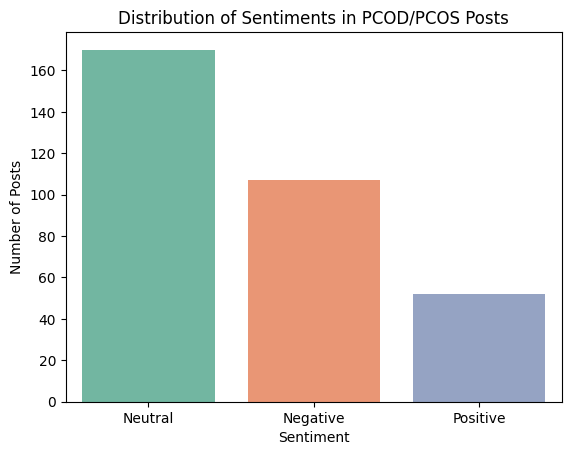

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Find the dominant sentiment
df['dominant_sentiment'] = df[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)

# Plot sentiment counts
sns.countplot(data=df, x='dominant_sentiment', palette='Set2')
plt.title("Distribution of Sentiments in PCOD/PCOS Posts")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")
plt.show()

/var/folders/p2/5zlctvqn3413625zm4c0bpfm0000gn/T/ipykernel_9104/828675323.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_emotion['dominant_emotion'] = df_emotion.idxmax(axis=1)
/var/folders/p2/5zlctvqn3413625zm4c0bpfm0000gn/T/ipykernel_9104/828675323.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='dominant_emotion', order=df['dominant_emotion'].value_counts().index, palette='coolwarm')


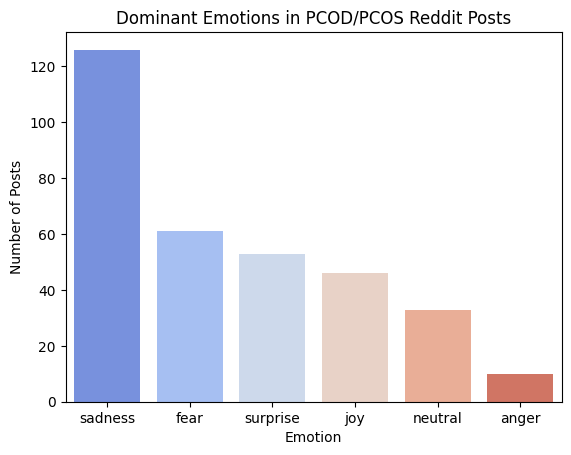

In [22]:
emotion_cols = ['joy', 'sadness', 'anger', 'love', 'fear', 'surprise']
df_emotion = df['emotion_scores'].apply(pd.Series)
df_emotion['dominant_emotion'] = df_emotion.idxmax(axis=1)

# Add dominant emotion to df
df['dominant_emotion'] = df_emotion['dominant_emotion']

# Plot
sns.countplot(data=df, x='dominant_emotion', order=df['dominant_emotion'].value_counts().index, palette='coolwarm')
plt.title("Dominant Emotions in PCOD/PCOS Reddit Posts")
plt.xlabel("Emotion")
plt.ylabel("Number of Posts")
plt.show()

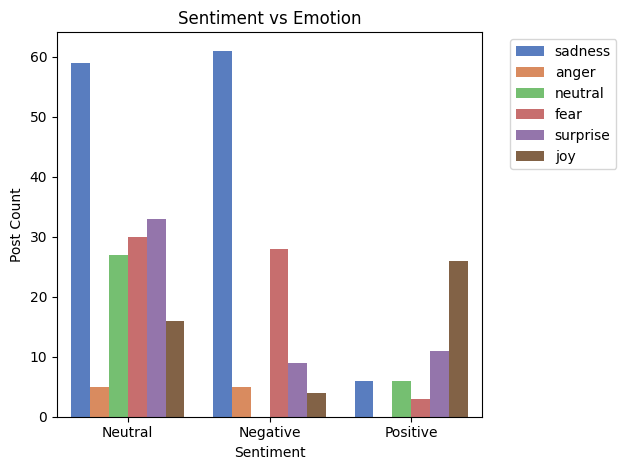

In [23]:
sns.countplot(data=df, x='dominant_sentiment', hue='dominant_emotion', palette='muted')
plt.title("Sentiment vs Emotion")
plt.xlabel("Sentiment")
plt.ylabel("Post Count")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()